# Quick intro


## Competition description
Imagine one day, your breathing became consistently labored and shallow. Months later you were finally diagnosed with pulmonary fibrosis, a disorder with no known cause and no known cure, created by scarring of the lungs. If that happened to you, you would want to know your prognosis. That’s where a troubling disease becomes frightening for the patient: outcomes can range from long-term stability to rapid deterioration, but doctors aren’t easily able to tell where an individual may fall on that spectrum. Your help, and data science, may be able to aid in this prediction, which would dramatically help both patients and clinicians.  

Current methods make fibrotic lung diseases difficult to treat, even with access to a chest CT scan. In addition, the wide range of varied prognoses create issues organizing clinical trials. Finally, patients suffer extreme anxiety—in addition to fibrosis-related symptoms—from the disease’s opaque path of progression.

Open Source Imaging Consortium (OSIC) is a not-for-profit, co-operative effort between academia, industry and philanthropy. The group enables rapid advances in the fight against Idiopathic Pulmonary Fibrosis (IPF), fibrosing interstitial lung diseases (ILDs), and other respiratory diseases, including emphysematous conditions. Its mission is to bring together radiologists, clinicians and computational scientists from around the world to improve imaging-based treatments.

In this competition, you’ll predict a patient’s severity of decline in lung function based on a CT scan of their lungs. You’ll determine lung function based on output from a spirometer, which measures the volume of air inhaled and exhaled. The challenge is to use machine learning techniques to make a prediction with the image, metadata, and baseline FVC as input.

If successful, patients and their families would better understand their prognosis when they are first diagnosed with this incurable lung disease. Improved severity detection would also positively impact treatment trial design and accelerate the clinical development of novel treatments.
 
 
### What should I expect the data format to be & what am I predicting?
Each row in the dataset contains a Patiend_ID, and a week; you must predict the FVC and a confidence. To avoid potential leakage in the timing of follow up visits, you are asked to predict every patient's FVC measurement for every possible week. Those weeks which are not in the final three visits are ignored in scoring.


The final submission-file should contain a header and have the following format:

```      Patient_Week,                 FVC,    Confidence
ID00002637202176704235138_1, 2000,   100
ID00002637202176704235138_2, 2000,   100
ID00002637202176704235138_3, 2000,   100
```



# Update history:

## New Notebook for CV-backed Random Grid Hyperparameter Search, click [here](https://www.kaggle.com/chrisden/6-82x-cv-backed-hyperp-gridsearch-quantile-reg)
V39: Optimized Wording, Hyperparameters, reduced NFOLDs  
V33: Improved logging
V30, 31: enhanced model-explanations (q1 and q_adjust layers) and outputs.
V24-29: Minor adoptions, testing multiple hyperparameters, correcting "MONITORING" during training: now correctly monitoring 'val_score' instead of 'score', which improves OOF score.  
V23: Minor optimizations, wording, hyperparameters
V19: Introduced plotting & evaluation of results  
V18: Introduced usage of tensorflow.addons (tfa): WeightNormalization  
V16: [Code optimizations](https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression/discussion/179033), see "third approach" in the Data-Wrangling section   
V13&14: small corrections, edited some links  
V12: Corrected bug for saving models correctly (see comment-section) & enhanced readabilty  
V11: Introduced model checkpoints/saving  
V10: Introduced configurable Learning-Rate-Schedulers  
V8&9: Introduced GroupKFolds to get leak-free cross-validation strategy to evaluate models & training


## Domain knowledge

### Some domain knowledge can be gained from watching the following video and from reading [here.](https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression/discussion/165727)

In [ ]:
from IPython.display import HTML
HTML('<center><iframe width="560" height="315" src="https://www.youtube.com/embed/AfK9LPNj-Zo" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></center>')

## Load all dependencies you need
<span style="color:darkgreen ;font-family: Impact; font-size:13;"> from  </span> coffee  <span style="color:darkgreen ;font-family: Impact; font-size:13;"> import  </span> ***** 

In [ ]:
import numpy as np
import random
import pandas as pd
import pydicom
import os
import matplotlib.pyplot as plt
from timeit import timeit
from tqdm import tqdm
from PIL import Image

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold

#color
from colorama import Fore, Back, Style

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as Layers
import warnings
warnings.filterwarnings('ignore') #Ignore "future" warnings and Data-Frame-Slicing warnings.


Let's start seeding everything to make results somewhat reproducible. Anyway, in keras it is quite hard to get 100% reproducible results.

In [ ]:
def seed_everything(seed): 
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

# First glimpse at the data

In [ ]:
ROOT = '../input/osic-pulmonary-fibrosis-progression'

train_df = pd.read_csv(f'{ROOT}/train.csv')
print(f'Train data has {train_df.shape[0]} rows and {train_df.shape[1]} columnns and looks like this:')


In [ ]:
train_df.sample(10)

To get an idea of the meaning of the weeks column, let's check some of their values.

In [ ]:
train_unique_df = train_df.drop_duplicates(subset = ['Patient'], keep = 'first')
train_unique_df.head()

As we can clearly see, some patients took the first measure of FVC before and some after their baseline CT images.
> the relative number of weeks pre/post the baseline CT (may be negative)

In [ ]:
# CHECK FOR DUPLICATES & DEAL WITH THEM
# keep = False: All duplicates will be shown
dupRows_df = train_df[train_df.duplicated(subset = ['Patient', 'Weeks'], keep = False )]
dupRows_df.head()

We can eighter drop all except the first or last duplicate or average them.As there are only a few duplicates, we can drop them without a bad conciousness for loosing to much data for our first apporach.

In [ ]:
train_df.drop_duplicates(subset=['Patient','Weeks'], keep = False, inplace = True)

In [ ]:
print(f'So there are {dupRows_df.shape[0]} (= {dupRows_df.shape[0] / train_df.shape[0] * 100:.2f}%) duplicates.')

In [ ]:
test_df = pd.read_csv(f'{ROOT}/test.csv')
print(f'Test data has {test_df.shape[0]} rows and {test_df.shape[1]} columnns, has no duplicates and looks like this:')
test_df.head()

# Data Wrangling

## Getting the format right

In this section we are going to do all the Data-Wrangling and pre-processing. For this we are going to define some functions and transformations, which then are applied to the data.
It's good practice to concatinate all tabular data (train, test, submission), to ensure all data get's the same & correct treatment.
If you don't do that, you need to be careful with some steps, e.g.: 
* Standardization or Normalization (e.g. MinMax Scaling) in ```test_df``` will not have the same range of values (e.g. min/max values) and therefore scaling than in ```train_df```.
* The categorical features might have different categories in ```test_df``` than in ```train_df``` (e.g. ```test_df``` only contains male, Ex-smokers).

So let's concatinate all our data first and then start with the transformations.

In [ ]:
## CHECK SUBMISSION FORMAT
sub_df = pd.read_csv(f"{ROOT}/sample_submission.csv")

print(f"The sample submission contains: {sub_df.shape[0]} rows and {sub_df.shape[1]} columns.")

In [ ]:
sub_df.head()

We need to get this into a format which we can easily use for making our predictions, so let's split up the ```Patient_Week``` column into a ```Patient``` and a ```Weeks``` column to align it with the train & test data-format.
Then we merge our info from the test data to the ```submission_df```: that's the fastest way of getting the correct format for predictions and submissions later on.

In [ ]:
# split Patient_Week Column and re-arrage columns
sub_df[['Patient','Weeks']] = sub_df.Patient_Week.str.split("_",expand = True)
sub_df =  sub_df[['Patient','Weeks','Confidence', 'Patient_Week']]

In [ ]:
sub_df = sub_df.merge(test_df.drop('Weeks', axis = 1), on = "Patient")

In [ ]:
# introduce a column to indicate the source (train/test) for the data
train_df['Source'] = 'train'
sub_df['Source'] = 'test'

data_df = train_df.append([sub_df])
data_df.reset_index(inplace = True)
data_df.head()


The first big challenge is data wrangling: 
We could see that some patients take FVE measurements only after their baseline CT-Images, and some took measurements before that.
So let's first find out what the actual baseline-week and baseline-FVC for each Patient is.  
We start with the baseline week:


In [ ]:
def get_baseline_week(df):
    # make a copy to not change original df    
    _df = df.copy()
    # ensure all Weeks values are INT and not accidentaly saved as string
    _df['Weeks'] = _df['Weeks'].astype(int)
    _df['min_week'] = _df['Weeks']
    # as test data is containing all weeks, 
    _df.loc[_df.Source == 'test','min_week'] = np.nan
    _df["min_week"] = _df.groupby('Patient')['Weeks'].transform('min')
    _df['baselined_week'] = _df['Weeks'] - _df['min_week']
    
    return _df   

In [ ]:
data_df = get_baseline_week(data_df)
data_df.head()

What we can see here, is that the Patient with ID ending on "430" had his first FVC measure 4 weeks before the first (baseline) CT images ( = "Weeks" column -4) were taken. Then the patient took the next FVC measurement 9 weeks later. 
In the next step we need to baseline the FVC values. Note, that the **BASELINE-FVC it not the minimum FVC**, but the first measurement, meaning the measurement taken in the "min_week" or ```baselined_week = 0```.

For getting the baselined FVC I first wrote the following straightforward function:

In [ ]:
def get_baseline_FVC_old(df):
    # copy the DF to not in-place change the original one
    _df = df.copy()
    # get only the rows containing the baseline (= min_weeks) and therefore the baseline FVC
    baseline = _df.loc[_df.Weeks == _df.min_week]
    baseline = baseline[['Patient','FVC']].copy()
    baseline.columns = ['Patient','base_FVC']      
    
    # fill the df with the baseline FVC values
    for idx in _df.index:
        patient_id = _df.at[idx,'Patient']
        _df.at[idx,'base_FVC'] = baseline.loc[baseline.Patient == patient_id, 'base_FVC'].iloc[0]
    _df.drop(['min_week'], axis = 1)
    
    return _df

This apporach works fine, but as it contains a lot of look-ups, its slow and didn't feel right.  
Btw: there is an even worse approach: Using ```for row in df.iterrows()``` is roughly 8 times slower than using ```for idx in df.index```.  
So I looked up how other people solved it and I found a rough equivalent to the following function:

In [ ]:
def get_baseline_FVC(df):
    # same as above
    _df = df.copy()
    base = _df.loc[_df.Weeks == _df.min_week]
    base = base[['Patient','FVC']].copy()
    base.columns = ['Patient','base_FVC']
    
    # add a row which contains the cumulated sum of rows for each patient
    base['nb'] = 1
    base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
    
    # drop all except the first row for each patient (= unique rows!), containing the min_week
    base = base[base.nb == 1]
    base.drop('nb', axis = 1, inplace = True)
    
    # merge the rows containing the base_FVC on the original _df
    _df = _df.merge(base, on = 'Patient', how = 'left')    
    _df.drop(['min_week'], axis = 1)
    
    return _df

The second apporach is using ```transform```, which is not as known as ```apply```, but faster for basic-operations not involving multiple columns of a dataframe. Here is an interesting post about it for those, who want to learn more:
[Apply vs transform.](https://stackoverflow.com/questions/27517425/apply-vs-transform-on-a-group-object)

It still wasn't perfect and I found a **third, super-clean approach** [here](https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression/discussion/179033):
    


In [ ]:
def get_baseline_FVC_new(df):
    _df = (
        df
        .loc[df.Weeks == df.min_week][['Patient','FVC']]
        .rename({'FVC': 'min_FVC'}, axis=1)
        .groupby('Patient')
        .first()
        .reset_index()
    )
    
    return _df


I wanted to know how much this speeds up the processing, you can find the results in the following:

In [ ]:
def old_baseline_FVC():
    return get_baseline_FVC_old(data_df)
    

def baseline_FVC():
    return get_baseline_FVC(data_df)

def baseline_FVC_new():
    return get_baseline_FVC_new(data_df)
    

duration_old = timeit(old_baseline_FVC, number = 3)
duration_baseline = timeit(baseline_FVC, number = 3)
duration_new = timeit(baseline_FVC_new, number = 3)

print(f"Taking the first, old & non-vectorized approach took {duration_old / 3:.2f} sec, while the 2nd, vectorized approach only took {duration_baseline / 3:.3f} sec. That's {duration_old/duration_baseline:.0f} times faster!" )
print(f"Taking the 3rd, newest, shortest and cleanest approach took {duration_new / 3:.3f} sec. That's {duration_old/duration_new:.0f} (!!) times faster!" )

Clearly, the third approach works best and I have learned a very clean way of processing data. 

In [ ]:
data_df = get_baseline_FVC(data_df)
data_df.head()

Not the data has the format we need to work with.
In the next section, we go trough two possibilities on how to normalize, standardize and prepare the data for the neural Network.

## Preparing the data for the Neural Network

### The first apporach is using sklearn, as it is super famous and used frequently.

In [ ]:
# import the necessary Encoders & Transformers
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer

# define which attributes shall not be transformed, are numeric or categorical
no_transform_attribs = ['Patient', 'Weeks', 'min_week']
num_attribs = ['FVC', 'Percent', 'Age', 'baselined_week', 'base_FVC']
cat_attribs = ['Sex', 'SmokingStatus']

To get a ColumnTransformer which outputs the whole DataFrame compatible format, we can create a class that takes attributes that we don't want to change, and simply passes them through.
This class needs a ```fit``` and a ```transform``` method, so that the ColumnTransformer itself can use ```fit_transform``` like for the numerical and categorical attributes.

As I learned in a comment from @frederiklaubisch, sklearns' ColumnTransformer has a 'remainder' parameter that can be set to 'passtrough', which would eliminate the need for the NoTranformer.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class NoTransformer(BaseEstimator, TransformerMixin):
    """Passes through data without any change and is compatible with ColumnTransformer class"""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X

In [ ]:
## GET TRANSFORMED DATAFRAME

# create an instance of the ColumnTransformer
datawrangler = ColumnTransformer(([
     # the No-Transformer does not change the data and is applied to all no_transform_attribs 
     ('original', NoTransformer(), no_transform_attribs),
     # Apply MinMax to the numerical attributes, here you can change to e.g. StdScaler()   
     ('MinMax', MinMaxScaler(), num_attribs),
     # OneHotEncoder all categorical attributes.   
     ('cat_encoder', OneHotEncoder(), cat_attribs),
    ]))

transformed_data_series = []
transformed_data_series = datawrangler.fit_transform(data_df)

Okay, now we encoded all the data and want to have a look at it. But wait, we only get back a series element? How to put that in a Dataframe again?
Sadly, not as easy as I had hoped. We need to use ```pd.DataFrame(data, columns=column_names)``` function, for which we need the column names. But we used OneHot-Encoding. So the number of columns now depends on how many different values/categories a categorical value has, because for each unique value we get a separate column: e.g. If for the column "SmokingStatus" we only have the values "Smoker" and "Never-Smoked", we have two resulting columns if there are additional possible values like "Ex_Smoker" we get more columns. And we also should not get things wrong and mix the columns up. The following code is getting our data back to a Dataframe and preserving the correct order.

In [ ]:
# get column names for non-categorical data
new_col_names = no_transform_attribs + num_attribs

# extract possible values from the fitted transformer
categorical_values = [s for s in datawrangler.named_transformers_["cat_encoder"].get_feature_names()]
new_col_names += categorical_values

# create Dataframe based on the extracted Column-Names
train_sklearn_df = pd.DataFrame(transformed_data_series, columns=new_col_names)
train_sklearn_df.head()

Okay wow, that was not as easy as I expected. The upside is, it's easy to add some additional features and pump them through the Pipeline or to change the Pipeline itself (e.g. exchanging MiNmaxScaler with StdScaler, RobustScaler etc).
The downside is: it's not intuitive (at least not for me) and takes quite some lines of code.
Does anybody have an idea on HOW to improve this? 

### The 2nd approach is doing all the legwork ourselfs.
The good thing is: we dont need a NoTransformer here, as we simply can work in the DataFrame itself and not change any data which we want to preserve.
Downside is, we need to implement the MinMaxScaler by hand. Make sure to not call it MinMaxScaler and shadow the already important MinMaxScaler from Sklearn!


In [ ]:
def own_MinMaxColumnScaler(df, columns):
    """Adds columns with scaled numeric values to range [0, 1]
    using the formula X_scld = (X - X.min) / (X.max - X.min)"""
    for col in columns:
        new_col_name = col + '_scld'
        col_min = df[col].min()
        col_max = df[col].max()        
        df[new_col_name] = (df[col] - col_min) / ( col_max - col_min )

In [ ]:
def own_OneHotColumnCreator(df, columns):
    """OneHot Encodes categorical features. Adds a column for each unique value per column"""
    for col in cat_attribs:
        for value in df[col].unique():
            df[value] = (df[col] == value).astype(int)

In [ ]:
## APPLY DEFINED TRANSFORMATIONS
own_MinMaxColumnScaler(data_df, num_attribs)
own_OneHotColumnCreator(data_df, cat_attribs)

data_df[data_df.Source != "train"].head()

In [ ]:
# get back original data split
train_df = data_df.loc[data_df.Source == 'train']
sub = data_df.loc[data_df.Source == 'test']

Okay, so the second apporach (using our own implementation) was more straightforward and less code.  Downside: if you want to replace the MinMaxScaler with another scaling method (RobustScaler, StdScaler), you need to implement it first.

# Model & Loss
In this section we are going to define the loss & a first model.
First we are taking care of the loss. We are trying to minimize the following:

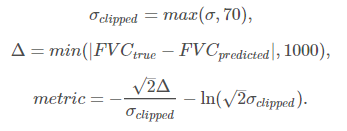

The global minimum of this function is achieved for delta = 0 and sigma = 70, which [results in a loss of roughly -4.59.](https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression/discussion/168469).

Getting our model to predict the Confidence and FVC values (which is what we need!) is not working fine so far, as you can read [here](https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression/discussion/167764).
Currently the way to go seems to be pinball loss. 


# <font color='blue'>CONFIG Section </font>

In this section you can configure the following:
* Features used for training
* Basic training setup: BATCH_SIZE and EPOCHS,
* Configuration for the loss function
* Optimizers, Learning-Rate-Schedulers incl. Learning Rate start- & endpoint
* Custom Logging Callback
* Checkpoint-Saving Callback

The Learning-Rate scheduler below is inspired by Chris great [Melanoma-detection notebook](https://www.kaggle.com/cdeotte/triple-stratified-kfold-with-tfrecords).  
Feel free to experiment with the scheduler and it's max/min and decay values.

**Ever wondered why lr_max is scaled by BATCH_SIZE and therefore bigger for larger batches?** The reason for this is the following: the larger the BATCH_SIZE, the more averaged & smoothened a step of gradient decent is and the bigger our confidence in the *direction* of the step is. As there is less "randomness" in a huge averaged batch (compared with for example Stochastic Gradient Decent (=SGD) with batch size = 1) and our confidence in the direction is higher, the learning rate can be bigger to advance fast to the optimum.

In [ ]:
######## CONFIG ########
# be careful, the resulsts are very SEED-DEPENDEND!
seed_everything(1989)


### Features: choose which features you want to use
# you can exclude and include features by extending this feature list
features_list = ['baselined_week_scld', 'Age_scld', 'base_FVC_scld', 'Male', 'Female', 'Ex-smoker', 'Never smoked', 'Currently smokes']

### Basics for training:
EPOCHS = 1500
BATCH_SIZE = 128


### LOSS; set tradeoff btw. Pinball-loss and adding score
_lambda = 0.8 # 0.8 default


### Optimizers
# choose ADAM or SGD
optimizer = 'SGD'

### Learning Rate Scheduler
def get_lr_callback(batch_size = 64, plot = False):
    """Returns a lr_scheduler callback which is used for training.
    Feel free to change the values below!
    """
    LR_START   = 0.001
    LR_MAX     = 0.0001 * BATCH_SIZE # higher batch size --> higher lr
    LR_MIN     = 0.000001
    # 30% of all epochs are used for ramping up the LR and then declining starts
    LR_RAMP_EP = EPOCHS * 0.3
    # how many epochs shall L_RMAX be sustained
    LR_SUS_EP  = 0
    # rate of decay
    LR_DECAY   = 0.993

    def lr_scheduler(epoch):
            if epoch < LR_RAMP_EP:
                lr = (LR_MAX - LR_START) / LR_RAMP_EP * epoch + LR_START

            elif epoch < LR_RAMP_EP + LR_SUS_EP:
                lr = LR_MAX

            else:
                lr = (LR_MAX - LR_MIN) * LR_DECAY ** (epoch - LR_RAMP_EP - LR_SUS_EP) + LR_MIN

            return lr
    
    if plot == False:
        # get the Keras-required callback with our LR for training
        lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler,verbose = False)
        return lr_callback 
    
    else: 
        return lr_scheduler
    
# plot & check the LR-Scheulder for sanity-check
lr_scheduler_plot = get_lr_callback(batch_size = 64, plot = True)
rng = [i for i in range(EPOCHS)]
y = [lr_scheduler_plot(x) for x in rng]
plt.plot(rng, y)
print(f"Learning rate schedule: {y[0]:.3f} to {max(y):.3f} to {y[-1]:.3f}")


# logging & saving
LOGGING = True

# defining custom callbacks
class LogPrintingCallback(tf.keras.callbacks.Callback):
    
    # defining a class variable which is used in the following
    # to ensure LogPrinting, evaluation & saving is consitent
    # choose between 'val_score' and 'val_loss'
    optimization_variable = 'val_loss'
    
    def on_train_begin(self, logs = None):
        #print("Training started for this fold")
        self.val_loss = []
        self.val_score = []        
        
    def on_epoch_end(self, epoch, logs = None):
        self.val_loss.append(logs['val_loss']) 
        self.val_score.append(logs['val_score'])
        if epoch % 250 == 0 or epoch == (EPOCHS -1 ):
            print(f"The average val-loss for epoch {epoch} is {logs['val_loss']:.2f}"
                  f" and the score is {logs['val_score']}")
            
    def on_train_end(self, logs = None):
        # get index of best epoch
        monitored_variable = self.val_loss if LogPrintingCallback.optimization_variable == 'val_loss' else self.val_score
        best_epoch = np.argmin(monitored_variable)        
        # get score in best epoch
        best_result_loss = self.val_loss[best_epoch]
        best_result_score = self.val_score[best_epoch]
        print(f"Best model was found and saved in epoch {best_epoch + 1} with val_loss: {best_result_loss} and val_score: {best_result_score} ") 
        
        
def get_checkpoint_saver_callback(fold):
    checkpt_saver = tf.keras.callbacks.ModelCheckpoint(
        'fold-%i.h5'%fold,
        monitor = 'val_score',
        verbose = 0,
        save_best_only = True,
        save_weights_only = True,
        mode = 'min',
        save_freq = 'epoch')
    
    return checkpt_saver

### Loss Function

In [ ]:
# create constants for the loss function
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")

# define competition metric
def score(y_true, y_pred):
    """Calculate the competition metric"""
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    sigma_clip = tf.maximum(sigma, C1)
    # Python is automatically broadcasting y_true with shape (1,0) to 
    # shape (3,0) in order to make this subtraction work
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype = tf.float32) )
    metric = (delta / sigma_clip) * sq2 + tf.math.log(sigma_clip * sq2)
    return K.mean(metric)

# define pinball loss
def qloss(y_true, y_pred):
    """Calculate Pinball loss"""
    # IMPORTANT: define quartiles, feel free to change here!
    qs = [0.2, 0.50, 0.8]
    q = tf.constant(np.array([qs]), dtype = tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q * e, (q-1) * e)
    return K.mean(v)

# combine competition metric and pinball loss to a joint loss function
def mloss(_lambda):
    """Combine Score and qloss"""
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda) * score(y_true, y_pred)
    return loss

## Neural Network Model
In this section we build an initial neural Network. The code of this section is derived from [Ulrich's](https://www.kaggle.com/ulrich07) great [notebook](https://www.kaggle.com/ulrich07/osic-multiple-quantile-regression-starter), which also inspired me to change my loss to the above coded version. Please support the original Notebook creators! The chosen quartiles are simply derived by testing; using 0.25 and 0.75 leads to worse results.

For the architecture: It's good practice to use numbers of units following the schema 2^x, with x element of N (= resulting in 1, 2, 4, 8, 16, 32, 64, 128,..).  
We are going to use dropout for regularization and not a too broad and deep network, as the training data is very limited.

### Normalization & Regularization
We are going to use weight-normalization (link to the paper, click [here](https://arxiv.org/abs/1602.07868)) from ```tensorflow_addons``` to support faster convergence. 
The authors describe the method like this:
> Weight normalization: a reparameterization of the weight vectors in a neural network that decouples the length of those weight vectors from their direction. By reparameterizing the weights in this way we improve the conditioning of the optimization problem and we speed up convergence of stochastic gradient descent. Our reparameterization is inspired by batch normalization but does not introduce any dependencies between the examples in a minibatch.

Additionally we gain more robustness for the choosing of the hyperparameter learning rate. Cited from page 3:
> Empirically, we find that the ability to grow the norm ||v|| makes optimization of neural networks
> with weight normalization very robust to the value of the learning rate: If the learning rate is too
> large, the norm of the unnormalized weights grows quickly until an appropriate effective learning rate
> is reached.

### Activation function
As the given task without the usage of images is not very compute-intensive (you don't need a GPU, CPU will do), we will change the activation-function from 'relu' to 'elu'.
For more info you can read [here.](https://mlfromscratch.com/activation-functions-explained/#elu), below you can find a short summary:

**Pros**
* Avoids the "dead ReLu" problem: ReLus provides activation-values & gradients of 0 for negative input values
* Produces activations for negative inputs instead of letting them be zero when calculating the gradient.
* Produces negative outputs, which helps the network nudge weights and biases in the right directions for negative inputs, too.

**Cons**
* Introduces longer computation time, because of the exponential operation included.
* Does not avoid the exploding gradient problem.

In [ ]:
import tensorflow_addons as tfa

def get_model(optimizer = 'ADAM', lr = 0.01):
    "Creates and returns a model"
    # instantiate optimizer
    optimizer = tf.keras.optimizers.Adam(lr = lr) if optimizer == 'ADAM' else tf.keras.optimizers.SGD(lr)
    
    # create model    
    inp = Layers.Input((len(features_list),), name = "Patient")
    x = Layers.BatchNormalization()(inp)
    x = tfa.layers.WeightNormalization(Layers.Dense(160, activation = "elu", name = "d1"))(x)
    x = Layers.BatchNormalization()(x)
    x = Layers.Dropout(0.3)(x)
    x = tfa.layers.WeightNormalization(Layers.Dense(128, activation = "elu", name = "d2"))(x)
    x = Layers.BatchNormalization()(x)
    x = Layers.Dropout(0.25)(x)
    # predicting the 3 quantiles
    q1 = Layers.Dense(3, activation = "relu", name = "p1")(x)
    # generating another output for quantile adjusting the quantile predictions
    q_adjust = Layers.Dense(3, activation = "relu", name = "p2")(x)
    
    # adding the tf.cumsum of q_adjust to the output q1
    # to ensure increasing values [a < b < c]
    # tf.cumsum([a, b, c]) --> [a, a + b, a + b + c]
    preds = Layers.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis = 1), 
                     name = "preds")([q1, q_adjust])
    
    model = tf.keras.Model(inputs = inp, outputs = preds, name = "NeuralNet")
    model.compile(loss = mloss(_lambda), optimizer = optimizer, metrics = [score])
    
    return model

### What about those mysterious quantiles (q1) and quantiles_adjustment (q_adjust) layers?
The idea of the q1 layer is to actually predict the 3 quantiles. As you can see in the loss function and in the neural network output: we expect 3 values, one value for each of the defined quantiles.

There are 2 reasons for the q_adjust layer:  
* First: With adding the cumulative sum on top of q1, we ensure (or at least very strongly support) that the output (preds) are in increasing order.
Let's consider two arrays/vectors: ```q1 = [a, b, c]``` ```q_adjust = [e, f, g]```. Then our output preds are ```q1 + tf.cumsum(q_adjust) = [a + e, b + e + f, c + e + f + g]```
* Second: We can see q_adjust as a *baseline* which is added to the q1 layers. It adds additional degrees of freedom (more neurons == more trainable weights), which provides better results. Theoretically we could also use only q1 and add tf.cumsum(q1), then we would guarantee that we have an increasing order, but we have less degrees of freedom and the OOF-Score and LB score is worse.

In [ ]:
# create neural Network
neuralNet = get_model(optimizer, lr = 0.01)
neuralNet.summary()

In [ ]:
## GET TRAINING DATA AND TARGET VALUE

# get target value
y = train_df['FVC'].values.astype(float)


# get training & test data
X_train = train_df[features_list].values
X_test = sub[features_list].values

# instantiate target arrays
train_preds = np.zeros((X_train.shape[0], 3))
test_preds = np.zeros((X_test.shape[0], 3))

# Training
In the following we want to create leak-free folds to get a robust **cross-validation strategy** in order to evaluate all our models & our training. The idea is to avoid having the same patient (= PatientID) in training- and in validation-Data, as this might lead to evaluate a higher CV-score for a model which is luckily learning/memorizing the data for a particular patientID which is also frequently occuring in the validation-data.  


The idea on how to do that is coming from @PAB97 [Pierre's great notebook (CHECK IT OUT!)](https://www.kaggle.com/rftexas/osic-eda-leak-free-kfold-cv-lgb-baseline#kln-440)
Please note, that we still don't use propoer stratification based on 'Age', 'Sex', 'SmokingStatus'.

In [ ]:
## Non-Stratified GroupKFold-split (can be further enhanced with stratification!)
"""K-fold variant with non-overlapping groups.
The same group will not appear in two different folds: in this case we dont want to have overlapping patientIDs in TRAIN and VAL-Data!
The folds are approximately balanced in the sense that the number of distinct groups is approximately the same in each fold."""

NFOLDS = 5
gkf = GroupKFold(n_splits = NFOLDS)
# extract Patient IDs for ensuring 
groups = train_df['Patient'].values

OOF_val_score = []
fold = 0

for train_idx, val_idx in gkf.split(X_train, y, groups = groups):
    fold += 1
    print(f"FOLD {fold}:")
    
    # callbacks: logging & model saving with checkpoints each fold
    # callbacks = [get_lr_callback(BATCH_SIZE)]  # un-comment for using LRScheduler
    reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                                          factor = 0.6,
                                                          patience = 150,
                                                          verbose = 1,
                                                          epsilon = 1e-4,
                                                          mode = 'min',
                                                          min_lr = 0.00001)
    
    callbacks = [reduce_lr_loss]
    
    if LOGGING == True:
        callbacks +=  [get_checkpoint_saver_callback(fold),                     
                     LogPrintingCallback()]

    # build and train model
    model = get_model(optimizer, lr = 0.005)
    history = model.fit(X_train[train_idx], y[train_idx], 
              batch_size = BATCH_SIZE, 
              epochs = EPOCHS, 
              validation_data = (X_train[val_idx], y[val_idx]), 
              callbacks = callbacks,
              verbose = 0) 
    
    # evaluate
    print("Train:", model.evaluate(X_train[train_idx], y[train_idx], verbose = 0, batch_size = BATCH_SIZE, return_dict = True))
    print("Val:", model.evaluate(X_train[val_idx], y[val_idx], verbose = 0, batch_size = BATCH_SIZE, return_dict = True))
    
    ## Load best model to make pred
    model.load_weights('fold-%i.h5'%fold)
    train_preds[val_idx] = model.predict(X_train[val_idx],
                                         batch_size = BATCH_SIZE,
                                         verbose = 0)
    
    # append OOF evaluation to calculate OFF_Score
    OOF_val_score.append(model.evaluate(X_train[val_idx], y[val_idx], verbose = 0, batch_size = BATCH_SIZE, return_dict = True)['score'])
    
    # predict on test set and average the predictions over all folds
    print("Predicting Test...")
    test_preds += model.predict(X_test, batch_size = BATCH_SIZE, verbose = 0) / NFOLDS

# Evaluation & submission

### Check loss and accuracy
Okay, we made it! Let's evaluate our model, check our stats (Out-Of-Fold log-loss) and submit it! Let's start with some plots.
Those plots can tell us, whether our model training is working as expected, or if it strongly overfits.  
The below **EXAMPLE-IMAGE** is an example of a strongly overfitting model:
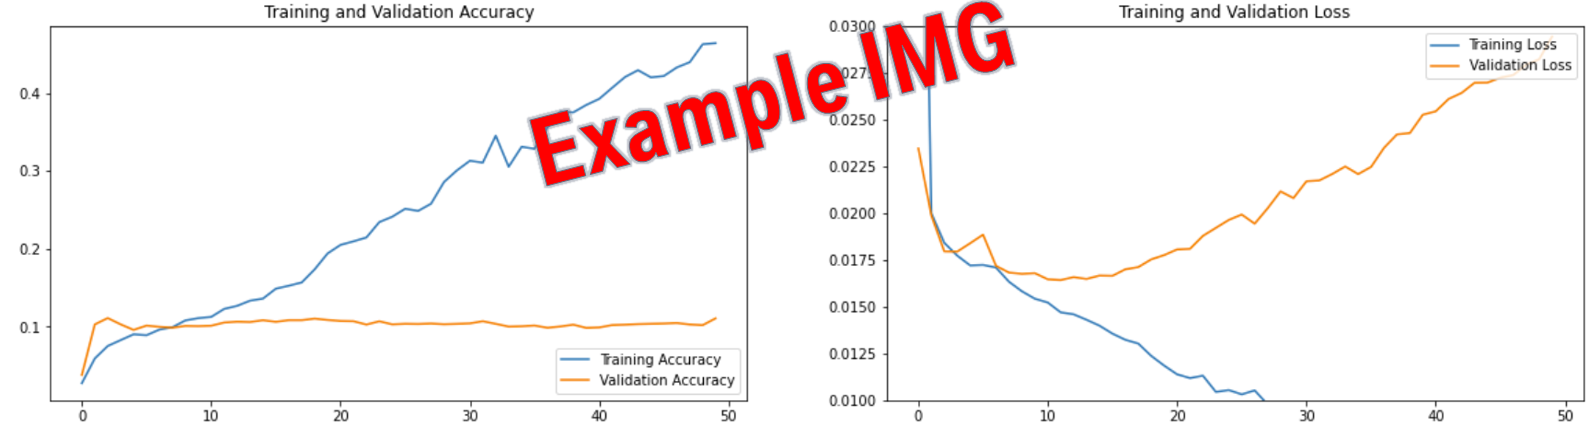
Long before we hit the 10th epoch, the validation loss is increasing again, while the training loss keeps decreasing. We can also clearly ovserve that there is no improvement in our accuracy anymore. 

What can we do against strongly overfitting models?
We could do the following:

* Collect more training data or use augmentation to generate new data: Sadly I have no brilliant idea on how to do this for this specific Kaggle competition.
* Reduce the network’s size (width andor/ dept) by removing layers or reducing the number of neurons in the hidden layers
* Use regularization like LASSO (=Least Absolute Shrinkage and Selection Operator; aka L1 regularization) or Ridge (aka L2 regularization) which results in adding a cost-term to the loss function
* Use higher dropout-rate in the Dropout-Layers, which will randomly remove more connections by setting them to zero and forcing the network to generalize better (=avoid relying on a limitied number of strong-influence neurons).

But now check our model's result and evaluate it:

In [ ]:
## PLOT results
# fetch results from history
score = history.history['score']
val_score = history.history['val_score']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

# create subplots
plt.figure(figsize = (20,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, score, label = 'Training Score')
plt.plot(epochs_range, val_score, label = 'Validation Score')
# limit y-values for better zoom-scale. Remember that roughly -4.5 is the best possible score
# plt.ylim(0.8 * np.mean(val_score), 1.2 * np.mean(val_score))
plt.legend(loc = 'lower right')
plt.title('Training and Validation Score')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
# limit y-values for beter zoom-scale
plt.ylim(0.3 * np.mean(val_loss), 1.8 * np.mean(val_loss))

plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

### OOF Evaluation

In [ ]:
np.mean(OOF_val_score)

In the next section we are going to use the ```train_preds``` to calculate the optimized sigma, which is a measure for certainty or rather uncertainty. We can do that, as we have both: the model's estimate and the real data. We subtract the lower quartile from the upper quartile (defined in the loss function) and average it.

In [ ]:
## FIND OPTIMIZED STANDARD-DEVIATION
sigma_opt = mean_absolute_error(y, train_preds[:,1])
sigma_uncertain = train_preds[:,2] - train_preds[:,0]
sigma_mean = np.mean(sigma_uncertain)
print(sigma_opt, sigma_mean)

In [ ]:
sub.head()

In [ ]:
## PREPARE SUBMISSION FILE WITH OUR PREDICTIONS
sub['FVC1'] = test_preds[:, 1]
sub['Confidence1'] = test_preds[:,2] - test_preds[:,0]

# get rid of unused data and show some non-empty data
submission = sub[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()
submission.loc[~submission.FVC1.isnull()].head(10)

In [ ]:
submission.loc[~submission.FVC1.isnull(),'FVC'] = submission.loc[~submission.FVC1.isnull(),'FVC1']

if sigma_mean < 70:
    submission['Confidence'] = sigma_opt
else:
    submission.loc[~submission.FVC1.isnull(),'Confidence'] = submission.loc[~submission.FVC1.isnull(),'Confidence1']

Okay, we made it! Let's finally check our stats and submit it!

In [ ]:
submission.head()

In [ ]:
submission.describe().T

In the following last step we overwrite our predictions with the known data from the orginal submission file to not waste known data.

In [ ]:
org_test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')

for i in range(len(org_test)):
    submission.loc[submission['Patient_Week']==org_test.Patient[i]+'_'+str(org_test.Weeks[i]), 'FVC'] = org_test.FVC[i]
    submission.loc[submission['Patient_Week']==org_test.Patient[i]+'_'+str(org_test.Weeks[i]), 'Confidence'] = 70

In [ ]:
submission[["Patient_Week","FVC","Confidence"]].to_csv("submission.csv", index = False)

## <font color='blue'>Thanks a lot for reading, I hope you could gain as much insights from reading this as I got from writing it.